# Optimization of Dissipative Qubit Reset

In [1]:
import qutip as qt

In [2]:
# NBVAL_IGNORE_OUTPUT
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
import math

$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{int}[0]{\text{int}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid
#2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

This example illustrates an optimization in an *open* quantum system,
where the dynamics is governed by the Liouville-von Neumann equation. Hence,
states are represented by density matrices $\op{\rho}(t)$ and the time-evolution
operator is given by a general dynamical map $\DynMap$.

## Define parameters

The system consists of a qubit with Hamiltonian
$\op{H}_{q}(t) = - \frac{\omega_{q}}{2} \op{\sigma}_{z} - \frac{\epsilon(t)}{2} \op{\sigma}_{z}$,
where $\omega_{q}$ is an energy level splitting that can be dynamically adjusted
by the control $\epsilon(t)$. This qubit couples strongly to another two-level
system (TLS) with Hamiltonian $\op{H}_{t} = - \frac{\omega_{t}}{2} \op{\sigma}_{z}$ with
static energy level splitting $\omega_{t}$. The coupling strength between both
systems is given by $J$ with the interaction Hamiltonian given by $\op{H}_{\int}
= J \op{\sigma}_{x} \otimes \op{\sigma}_{x}$.

The Hamiltonian for the system of qubit and TLS is

$$
  \op{H}(t)
    = \op{H}_{q}(t) \otimes \identity_{t}
      + \identity_{q} \otimes \op{H}_{t} + \op{H}_{\int}.
$$

In addition, the TLS is embedded in a heat bath with inverse temperature
$\beta$. The TLS couples to the bath with rate $\kappa$. In order to simulate
the dissipation arising from this coupling, we consider the two Lindblad
operators

$$
\begin{split}
\op{L}_{1} &= \sqrt{\kappa (N_{th}+1)} \identity_{q} \otimes \ket{0}\bra{1} \\
\op{L}_{2} &= \sqrt{\kappa N_{th}} \identity_{q} \otimes \ket{1}\bra{0}
\end{split}
$$

with $N_{th} = 1/(e^{\beta \omega_{t}} - 1)$.

In [39]:
omega = 1  # qubit level splitting
g = 0.2*omega  # qubit-TLS coupling
gamma = 0.05*omega  # TLS decay rate
N=0  # inverse bath temperature
T = np.pi/g  # final time
nt = 800  # number of time steps

## Define the Liouvillian

The dynamics of the qubit-TLS system state $\op{\rho}(t)$ is governed by the
Liouville-von Neumann equation

$$
\begin{split}
  \frac{\partial}{\partial t} \op{\rho}(t)
    &= \Liouville(t) \op{\rho}(t) \\
    &= - i \left[\op{H}(t), \op{\rho}(t)\right]
      + \sum_{k=1,2} \left(
            \op{L}_{k} \op{\rho}(t) \op{L}_{k}^\dagger
            - \frac{1}{2}
            \op{L}_{k}^\dagger
            \op{L}_{k} \op{\rho}(t)
            - \frac{1}{2} \op{\rho}(t)
            \op{L}_{k}^\dagger
            \op{L}_{k}
        \right)\,.
\end{split}
$$

In [40]:
qutip.tensor(qutip.qeye(2),qutip.qeye(2),qutip.qeye(2))

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]

In [41]:
def liouvillian(omega, g, gamma, N):
    """Liouvillian for the coupled system of qubit and TLS"""

    H0_q = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))
    # drive qubit Hamiltonian
    H1_q = -0.5*qutip.operators.sigmax()

    # drift TLS Hamiltonian
    H0_T = qutip.tensor(omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)), qutip.qeye(2), qutip.qeye(2))\
            +qutip.tensor(qutip.qeye(2), omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)), qutip.qeye(2))\
            +qutip.tensor(qutip.qeye(2), qutip.qeye(2), omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)))

    # Lift Hamiltonians to joint system operators
    H0 = qutip.tensor(H0_q, qutip.qeye(2),qutip.qeye(2),qutip.qeye(2)) + qutip.tensor(qutip.qeye(2), H0_T)
    H1 = qutip.tensor(H1_q, qutip.qeye(2), qutip.qeye(2),qutip.qeye(2))

    # qubit-TLS interaction
    H_int = g*(qutip.tensor(qutip.destroy(2),qutip.create(2),qutip.qeye(2),qutip.qeye(2))\
                +qutip.tensor(qutip.create(2),qutip.destroy(2),qutip.qeye(2),qutip.qeye(2))\
                +qutip.tensor(qutip.destroy(2),qutip.qeye(2),qutip.create(2),qutip.qeye(2))\
                +qutip.tensor(qutip.create(2),qutip.qeye(2),qutip.destroy(2),qutip.qeye(2))\
                +qutip.tensor(qutip.destroy(2),qutip.qeye(2),qutip.qeye(2),qutip.create(2))\
                +qutip.tensor(qutip.create(2),qutip.qeye(2),qutip.qeye(2),qutip.destroy(2)))


    # convert Hamiltonians to QuTiP objects
    H0 = qutip.Qobj(H0 + H_int)
    H1 = qutip.Qobj(H1)

    # Define Lindblad operators
    # Cooling on TLS
    L1 = np.sqrt(gamma * (N + 1)) * qutip.tensor(qutip.destroy(2),qutip.qeye(2),qutip.qeye(2),qutip.qeye(2))
    # Heating on TLS
    L2 = np.sqrt(gamma * N) *qutip.tensor(qutip.create(2),qutip.qeye(2),qutip.qeye(2),qutip.qeye(2))
    

    # convert Lindblad operators to QuTiP objects
    L1 = qutip.Qobj(L1)
    L2 = qutip.Qobj(L2)

    # generate the Liouvillian
    L0 = qutip.liouvillian(H=H0, c_ops=[L1, L2])
    L1 = qutip.liouvillian(H=H1)

    # Shift the qubit and TLS into resonance by default
    eps0 = lambda t, args: 1
    return [L0, [L1, eps0]]


L = liouvillian(omega, g, gamma, N)

## Define the optimization target

The initial state of qubit and TLS are assumed to be in thermal equilibrium with
the heat bath (although only the TLS is directly interacting with the bath).
Both states are given by

$$
  \op{\rho}_{\alpha}^{th} =
\frac{e^{x_{\alpha}} \ket{0}\bra{0} + e^{-x_{\alpha}} \ket{1}\bra{1}}{2
\cosh(x_{\alpha})},
  \qquad
  x_{\alpha} = \frac{\omega_{\alpha} \beta}{2},
$$

with $\alpha = q,t$. The initial state of the bipartite system
of qubit and TLS is given by the thermal state
$\op{\rho}_{th} = \op{\rho}_{q}^{th} \otimes \op{\rho}_{t}^{th}$.

In [42]:
rho_th = qutip.Qobj(qutip.tensor(qutip.basis(2,0)*qutip.basis(2,0).dag(),qutip.basis(2,0)*qutip.basis(2,0).dag(),qutip.basis(2,0)*qutip.basis(2,0).dag(),qutip.basis(2,0)*qutip.basis(2,0).dag()))
print(rho_th)

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Since we are ultimately only interested in the state of the qubit, we define
`trace_A`. It returns the reduced state of the qubit
$\op{\rho}_{q} = \tr_{t}\{\op{\rho}\}$ when passed
the state $\op{\rho}$ of the bipartite system.

In [43]:
def trace_A(rho):
    """Partial trace over the A degrees of freedom"""
    rho_q = np.zeros(shape=(2, 2), dtype=np.complex_)
    rho_q[0, 0] = rho[0, 0] + rho[2, 2]
    rho_q[0, 1] = rho[0, 1] + rho[2, 3]
    rho_q[1, 0] = rho[1, 0] + rho[3, 2]
    rho_q[1, 1] = rho[1, 1] + rho[3, 3]
    return qutip.Qobj(rho_q)

The target state is (temporarily) the ground state of the bipartite system,
i.e., $\op{\rho}_{\tgt} = \ket{00}\bra{00}$. Note that in the end we will only
optimize the reduced state of the qubit.

In [44]:
rho_q_trg = qutip.Qobj(np.diag([1, 0]))
rho_T_trg = qutip.tensor(qutip.Qobj(np.diag([0, 1])),qutip.Qobj(np.diag([0,1])),qutip.Qobj(np.diag([0,1])))
rho_trg = qutip.tensor(rho_q_trg, rho_T_trg)
rho_trg = qutip.Qobj(rho_trg)
print(rho_trg)

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Next, the list of `objectives` is defined, which contains the initial and target
state and the Liouvillian $\Liouville(t)$ that determines the system dynamics.

In [45]:
objectives = [krotov.Objective(initial_state=rho_th, target=rho_trg, H=L)]

In the following, we define the shape function $S(t)$, which we use in order to
ensure a smooth switch on and off in the beginning and end. Note that at times
$t$ where $S(t)$ vanishes, the updates of the field is suppressed.

In [46]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=T, t_rise=0.005 * T, t_fall=0.005 * T, func='sinsq'
    )

We re-use this function to also shape the guess control $\epsilon_{0}(t)$ to be
zero at $t=0$ and $t=T$. This is on top of the originally defined constant
value shifting the qubit and TLS into resonance.

In [47]:
def shape_field(eps0):
    """Applies the shape function S(t) to the guess field"""
    eps0_shaped = lambda t, args: 0.75*eps0(t, args) * S(t)
    return eps0_shaped


L[1][1] =shape_field(L[1][1])

At last, before heading to the actual optimization below, we assign the shape
function $S(t)$ to the OCT parameters of the control and choose `lambda_a`, a
numerical parameter that controls the field update magnitude in each iteration.

In [48]:
pulse_options = {L[1][1]: dict(lambda_a=1.5, update_shape=S)}

## Simulate the dynamics of the guess field


In [49]:
tlist = np.linspace(0, T, nt)

The following plot shows the guess field $\epsilon_{0}(t)$ as a constant that
puts qubit and TLS into resonance, but with a smooth switch-on and switch-off.

We solve the equation of motion for this guess field, storing the expectation
values for the population in the bipartite levels:


The population dynamics of qubit and TLS ground state show that
both are oscillating and especially the qubit's ground state population reaches
a maximal value at intermediate times $t < T$. This maximum is indeed the
maximum that is physically possible. It corresponds to a perfect swap of
the initial qubit and TLS purities. However, we want to reach this maximum at
final time $T$ (not before), so the guess control is not yet working as desired.

## Optimize

Our optimization target is the ground state $\ket{\Psi_{q}^{\tgt}}
= \ket{0}$ of the qubit, irrespective of the state of the TLS. Thus, our
optimization functional reads

$$
  J_T = 1 -
\Braket{\Psi_{q}^{\tgt}}{\tr_{t}\{\op{\rho}(T)\} \,|\; \Psi_{q}^{\tgt}}\,,
$$

and we first define `print_qubit_error`, which prints out the
above functional after each iteration.


In [50]:
def print_qubit_error(**args):
    """Utility function writing the qubit error to screen"""
    taus = []
    for state_T in args['fw_states_T']:
        state_q_T = np.trace(np.array(state_T).reshape(2,2,2,2,2,2,2,2), axis1=0, axis2=4)
        FinalStateB=state_q_T.reshape(8,8)       
        taus.append(FinalStateB[7, 7].real)
    J_T = 1 - np.average(taus)
    print("    qubit error: %.1e" % J_T)
    return J_T

In order to minimize the above functional, we need to provide the correct
`chi_constructor` for the Krotov optimization. This is the only place where the
functional (implicitly) enters the optimization.
Given our bipartite system and choice of $J_T$, the equation for
$\op{\chi}(T)$ reads

$$
  \op{\chi}(T)
  =
  \frac{1}{2} \ket{\Psi_{q}^{\tgt}} \bra{\Psi_{q}^{\tgt}} \otimes \op{1}_{2}
  =
  \frac{1}{2} \ket{00}\bra{00} + \frac{1}{2} \ket{01}\bra{01}.
$$

In [51]:
def chis_qubit(fw_states_T, objectives, tau_vals):
    """Calculate chis for the chosen functional"""
    chis = []
    for state_i_T in fw_states_T:
        chi_i = qutip.Qobj(qutip.tensor(qt.qeye(2),rho_T_trg))
        chis.append(chi_i)
    return chis

We now carry out the optimization for five iterations.

In [52]:
def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """

    fig, [ax_ctr,ax] = plt.subplots(nrows=2, figsize=(4, 5))
    n_iters = len(opt_result.iters)
    EEnergy=np.zeros(nt)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            krotov.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=[]
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'guess'
            pop_labels = ['0 (guess)', '1 (guess)']
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'optimized'
            pop_labels = ['0 (optimized)', '1 (optimized)']
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None, None]
        ax_ctr.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
    EField=np.transpose(np.array(opt_result.optimized_controls))
    EEnergy[0]=(np.square(EField[0]))*(T/nt)
    a=0
    for i in range (1,nt):
      a+=np.square(EField[i-1])
      EEnergy[i]=(np.square(EField[i])+a)*(T/nt)
      
    
    ax.plot(tlist,np.transpose(EEnergy))
    plt.legend()
    plt.show(fig)

Iteration 0
    objectives:
        1:ρ₄[2⊗2⊗2⊗2,2⊗2⊗2⊗2] to ρ₅[2⊗2⊗2⊗2,2⊗2⊗2⊗2] via [𝓛₄[[2⊗2⊗2⊗2,2⊗2⊗2⊗2],[2⊗2⊗2⊗2,2⊗2⊗2⊗2]], [𝓛₅[[2⊗2⊗2⊗2,2⊗2⊗2⊗2],[2⊗2⊗2⊗2,2⊗2⊗2⊗2]], u₂(t)]]
    adjoint objectives:
        1:ρ₆[2⊗2⊗2⊗2,2⊗2⊗2⊗2] to ρ₇[2⊗2⊗2⊗2,2⊗2⊗2⊗2] via [𝓛₆[[2⊗2⊗2⊗2,2⊗2⊗2⊗2],[2⊗2⊗2⊗2,2⊗2⊗2⊗2]], [𝓛₇[[2⊗2⊗2⊗2,2⊗2⊗2⊗2],[2⊗2⊗2⊗2,2⊗2⊗2⊗2]], u₂(t)]]
    chi_constructor: chis_qubit
    mu: derivative_wrt_pulse
    S(t) (ranges): [0.000000, 1.000000]
    iter_start: 0
    iter_stop: 20000
    duration: 0.1 secs (started at 2023-01-25 13:03:38)
    optimized pulses (ranges): [0.00, 0.75]
    ∫gₐ(t)dt: 0.00e+00
    λₐ: 1.50e+00
    storage (bw, fw, fw0): None, None, None
    fw_states_T norm: 1.000000
    τ: (9.00e-05:0.00π)
    qubit error: 1.0e+00
Iteration 1
    duration: 0.8 secs (started at 2023-01-25 13:03:38)
    optimized pulses (ranges): [0.00, 0.75]
    ∫gₐ(t)dt: 9.85e-08
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000

    qubit error: 1.0e+00
Iteration 26
    duration: 1.3 secs (started at 2023-01-25 13:04:04)
    optimized pulses (ranges): [0.00, 0.76]
    ∫gₐ(t)dt: 1.36e-07
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.41e-05:0.00π)
    qubit error: 1.0e+00
Iteration 27
    duration: 1.3 secs (started at 2023-01-25 13:04:05)
    optimized pulses (ranges): [0.00, 0.76]
    ∫gₐ(t)dt: 1.38e-07
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.42e-05:0.00π)
    qubit error: 1.0e+00
Iteration 28
    duration: 1.3 secs (started at 2023-01-25 13:04:06)
    optimized pulses (ranges): [0.00, 0.76]
    ∫gₐ(t)dt: 1.40e-07
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (9.44e-05:0.00π)
    qubit error: 1.0e+00
Iteration 29
    duration: 1.3 secs (started at 2023-01-25 13:04:08)
    op

    qubit error: 1.0e+00
Iteration 54
    duration: 1.2 secs (started at 2023-01-25 13:04:38)
    optimized pulses (ranges): [0.00, 0.76]
    ∫gₐ(t)dt: 2.17e-07
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.01e-04:0.00π)
    qubit error: 1.0e+00
Iteration 55
    duration: 1.2 secs (started at 2023-01-25 13:04:40)
    optimized pulses (ranges): [0.00, 0.76]
    ∫gₐ(t)dt: 2.22e-07
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.01e-04:0.00π)
    qubit error: 1.0e+00
Iteration 56
    duration: 1.2 secs (started at 2023-01-25 13:04:41)
    optimized pulses (ranges): [0.00, 0.76]
    ∫gₐ(t)dt: 2.26e-07
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.01e-04:0.00π)
    qubit error: 1.0e+00
Iteration 57
    duration: 1.2 secs (started at 2023-01-25 13:04:42)
    op

    qubit error: 1.0e+00
Iteration 82
    duration: 1.6 secs (started at 2023-01-25 13:05:16)
    optimized pulses (ranges): [0.00, 0.77]
    ∫gₐ(t)dt: 3.88e-07
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.12e-04:0.00π)
    qubit error: 1.0e+00
Iteration 83
    duration: 1.6 secs (started at 2023-01-25 13:05:18)
    optimized pulses (ranges): [0.00, 0.77]
    ∫gₐ(t)dt: 3.97e-07
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.13e-04:0.00π)
    qubit error: 1.0e+00
Iteration 84
    duration: 1.5 secs (started at 2023-01-25 13:05:20)
    optimized pulses (ranges): [0.00, 0.77]
    ∫gₐ(t)dt: 4.06e-07
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.13e-04:0.00π)
    qubit error: 1.0e+00
Iteration 85
    duration: 1.5 secs (started at 2023-01-25 13:05:21)
    op

    qubit error: 1.0e+00
Iteration 110
    duration: 1.4 secs (started at 2023-01-25 13:05:57)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 7.53e-07
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.34e-04:0.00π)
    qubit error: 1.0e+00
Iteration 111
    duration: 1.5 secs (started at 2023-01-25 13:05:58)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 7.73e-07
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.35e-04:0.00π)
    qubit error: 1.0e+00
Iteration 112
    duration: 1.4 secs (started at 2023-01-25 13:06:00)
    optimized pulses (ranges): [0.00, 0.79]
    ∫gₐ(t)dt: 7.92e-07
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.36e-04:0.00π)
    qubit error: 1.0e+00
Iteration 113
    duration: 1.5 secs (started at 2023-01-25 13:06:01)
  

    qubit error: 1.0e+00
Iteration 138
    duration: 1.4 secs (started at 2023-01-25 13:06:40)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 1.57e-06
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.78e-04:0.00π)
    qubit error: 1.0e+00
Iteration 139
    duration: 1.4 secs (started at 2023-01-25 13:06:41)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 1.61e-06
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.80e-04:0.00π)
    qubit error: 1.0e+00
Iteration 140
    duration: 1.4 secs (started at 2023-01-25 13:06:43)
    optimized pulses (ranges): [0.00, 0.81]
    ∫gₐ(t)dt: 1.66e-06
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.83e-04:0.00π)
    qubit error: 1.0e+00
Iteration 141
    duration: 1.4 secs (started at 2023-01-25 13:06:44)
  

    qubit error: 1.0e+00
Iteration 166
    duration: 1.6 secs (started at 2023-01-25 13:07:23)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 3.48e-06
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.74e-04:0.00π)
    qubit error: 1.0e+00
Iteration 167
    duration: 1.5 secs (started at 2023-01-25 13:07:24)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 3.58e-06
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.79e-04:0.00π)
    qubit error: 1.0e+00
Iteration 168
    duration: 1.5 secs (started at 2023-01-25 13:07:26)
    optimized pulses (ranges): [0.00, 0.84]
    ∫gₐ(t)dt: 3.69e-06
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.85e-04:0.00π)
    qubit error: 1.0e+00
Iteration 169
    duration: 1.5 secs (started at 2023-01-25 13:07:27)
  

    qubit error: 1.0e+00
Iteration 194
    duration: 1.7 secs (started at 2023-01-25 13:08:07)
    optimized pulses (ranges): [0.00, 0.88]
    ∫gₐ(t)dt: 8.45e-06
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.99e-04:0.00π)
    qubit error: 1.0e+00
Iteration 195
    duration: 1.7 secs (started at 2023-01-25 13:08:08)
    optimized pulses (ranges): [0.00, 0.88]
    ∫gₐ(t)dt: 8.73e-06
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (5.12e-04:0.00π)
    qubit error: 1.0e+00
Iteration 196
    duration: 1.6 secs (started at 2023-01-25 13:08:10)
    optimized pulses (ranges): [0.00, 0.88]
    ∫gₐ(t)dt: 9.03e-06
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (5.25e-04:0.00π)
    qubit error: 1.0e+00
Iteration 197
    duration: 1.5 secs (started at 2023-01-25 13:08:12)
  

    qubit error: 1.0e+00
Iteration 222
    duration: 1.6 secs (started at 2023-01-25 13:08:51)
    optimized pulses (ranges): [0.00, 0.94]
    ∫gₐ(t)dt: 2.42e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.10e-03:0.00π)
    qubit error: 1.0e+00
Iteration 223
    duration: 1.7 secs (started at 2023-01-25 13:08:52)
    optimized pulses (ranges): [0.00, 0.95]
    ∫gₐ(t)dt: 2.53e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.13e-03:0.00π)
    qubit error: 1.0e+00
Iteration 224
    duration: 1.7 secs (started at 2023-01-25 13:08:54)
    optimized pulses (ranges): [0.00, 0.95]
    ∫gₐ(t)dt: 2.64e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (1.17e-03:0.00π)
    qubit error: 1.0e+00
Iteration 225
    duration: 1.7 secs (started at 2023-01-25 13:08:56)
  

    qubit error: 1.0e+00
Iteration 250
    duration: 1.6 secs (started at 2023-01-25 13:09:36)
    optimized pulses (ranges): [0.00, 1.05]
    ∫gₐ(t)dt: 1.02e-04
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.21e-03:0.00π)
    qubit error: 1.0e+00
Iteration 251
    duration: 1.6 secs (started at 2023-01-25 13:09:38)
    optimized pulses (ranges): [0.00, 1.06]
    ∫gₐ(t)dt: 1.09e-04
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.37e-03:0.00π)
    qubit error: 1.0e+00
Iteration 252
    duration: 1.6 secs (started at 2023-01-25 13:09:39)
    optimized pulses (ranges): [0.00, 1.06]
    ∫gₐ(t)dt: 1.17e-04
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.53e-03:0.00π)
    qubit error: 1.0e+00
Iteration 253
    duration: 1.9 secs (started at 2023-01-25 13:09:41)
  

    qubit error: 9.8e-01
Iteration 278
    duration: 2.8 secs (started at 2023-01-25 13:10:28)
    optimized pulses (ranges): [0.00, 1.31]
    ∫gₐ(t)dt: 1.45e-03
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.08e-02:0.00π)
    qubit error: 9.8e-01
Iteration 279
    duration: 2.0 secs (started at 2023-01-25 13:10:31)
    optimized pulses (ranges): [0.00, 1.33]
    ∫gₐ(t)dt: 1.68e-03
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.30e-02:0.00π)
    qubit error: 9.7e-01
Iteration 280
    duration: 2.9 secs (started at 2023-01-25 13:10:33)
    optimized pulses (ranges): [0.00, 1.35]
    ∫gₐ(t)dt: 1.95e-03
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.57e-02:0.00π)
    qubit error: 9.7e-01
Iteration 281
    duration: 2.0 secs (started at 2023-01-25 13:10:36)
  

    qubit error: 3.7e-01
Iteration 306
    duration: 1.8 secs (started at 2023-01-25 13:11:23)
    optimized pulses (ranges): [-1.06, 2.63]
    ∫gₐ(t)dt: 7.67e-03
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.30e-01:0.00π)
    qubit error: 3.6e-01
Iteration 307
    duration: 1.8 secs (started at 2023-01-25 13:11:25)
    optimized pulses (ranges): [-1.07, 2.67]
    ∫gₐ(t)dt: 6.33e-03
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.31e-01:0.00π)
    qubit error: 3.5e-01
Iteration 308
    duration: 1.8 secs (started at 2023-01-25 13:11:27)
    optimized pulses (ranges): [-1.06, 2.72]
    ∫gₐ(t)dt: 5.28e-03
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (4.30e-01:0.00π)
    qubit error: 3.4e-01
Iteration 309
    duration: 1.8 secs (started at 2023-01-25 13:11:29)

    qubit error: 2.7e-01
Iteration 334
    duration: 1.9 secs (started at 2023-01-25 13:12:16)
    optimized pulses (ranges): [-1.03, 3.14]
    ∫gₐ(t)dt: 1.13e-03
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.40e-01:0.00π)
    qubit error: 2.6e-01
Iteration 335
    duration: 1.8 secs (started at 2023-01-25 13:12:18)
    optimized pulses (ranges): [-1.03, 3.15]
    ∫gₐ(t)dt: 1.10e-03
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.36e-01:0.00π)
    qubit error: 2.6e-01
Iteration 336
    duration: 1.9 secs (started at 2023-01-25 13:12:19)
    optimized pulses (ranges): [-1.03, 3.15]
    ∫gₐ(t)dt: 1.06e-03
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (3.34e-01:0.00π)
    qubit error: 2.6e-01
Iteration 337
    duration: 1.8 secs (started at 2023-01-25 13:12:21)

    qubit error: 2.3e-01
Iteration 362
    duration: 1.9 secs (started at 2023-01-25 13:13:09)
    optimized pulses (ranges): [-1.02, 3.21]
    ∫gₐ(t)dt: 5.39e-04
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.75e-01:0.00π)
    qubit error: 2.3e-01
Iteration 363
    duration: 1.8 secs (started at 2023-01-25 13:13:10)
    optimized pulses (ranges): [-1.02, 3.21]
    ∫gₐ(t)dt: 5.29e-04
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.74e-01:0.00π)
    qubit error: 2.3e-01
Iteration 364
    duration: 1.8 secs (started at 2023-01-25 13:13:12)
    optimized pulses (ranges): [-1.02, 3.21]
    ∫gₐ(t)dt: 5.14e-04
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.72e-01:0.00π)
    qubit error: 2.3e-01
Iteration 365
    duration: 1.8 secs (started at 2023-01-25 13:13:14)

    qubit error: 2.2e-01
Iteration 390
    duration: 1.8 secs (started at 2023-01-25 13:14:01)
    optimized pulses (ranges): [-1.13, 3.25]
    ∫gₐ(t)dt: 2.92e-04
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.52e-01:0.00π)
    qubit error: 2.2e-01
Iteration 391
    duration: 1.8 secs (started at 2023-01-25 13:14:03)
    optimized pulses (ranges): [-1.13, 3.25]
    ∫gₐ(t)dt: 2.89e-04
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.52e-01:0.00π)
    qubit error: 2.2e-01
Iteration 392
    duration: 1.9 secs (started at 2023-01-25 13:14:05)
    optimized pulses (ranges): [-1.14, 3.25]
    ∫gₐ(t)dt: 2.78e-04
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.51e-01:0.00π)
    qubit error: 2.2e-01
Iteration 393
    duration: 2.1 secs (started at 2023-01-25 13:14:07)

    qubit error: 2.1e-01
Iteration 418
    duration: 2.1 secs (started at 2023-01-25 13:14:54)
    optimized pulses (ranges): [-1.25, 3.33]
    ∫gₐ(t)dt: 1.86e-04
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.46e-01:0.00π)
    qubit error: 2.1e-01
Iteration 419
    duration: 2.2 secs (started at 2023-01-25 13:14:56)
    optimized pulses (ranges): [-1.25, 3.34]
    ∫gₐ(t)dt: 1.83e-04
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.47e-01:0.00π)
    qubit error: 2.1e-01
Iteration 420
    duration: 2.1 secs (started at 2023-01-25 13:14:58)
    optimized pulses (ranges): [-1.25, 3.34]
    ∫gₐ(t)dt: 1.79e-04
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.46e-01:0.00π)
    qubit error: 2.1e-01
Iteration 421
    duration: 1.8 secs (started at 2023-01-25 13:15:00)

    qubit error: 2.0e-01
Iteration 446
    duration: 1.8 secs (started at 2023-01-25 13:15:48)
    optimized pulses (ranges): [-1.35, 3.43]
    ∫gₐ(t)dt: 1.37e-04
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.47e-01:0.00π)
    qubit error: 2.0e-01
Iteration 447
    duration: 1.8 secs (started at 2023-01-25 13:15:50)
    optimized pulses (ranges): [-1.35, 3.44]
    ∫gₐ(t)dt: 1.39e-04
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.47e-01:0.00π)
    qubit error: 2.0e-01
Iteration 448
    duration: 1.9 secs (started at 2023-01-25 13:15:52)
    optimized pulses (ranges): [-1.36, 3.44]
    ∫gₐ(t)dt: 1.37e-04
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.47e-01:0.00π)
    qubit error: 2.0e-01
Iteration 449
    duration: 2.0 secs (started at 2023-01-25 13:15:54)

    qubit error: 2.0e-01
Iteration 474
    duration: 1.8 secs (started at 2023-01-25 13:16:41)
    optimized pulses (ranges): [-1.45, 3.54]
    ∫gₐ(t)dt: 1.14e-04
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.49e-01:0.00π)
    qubit error: 2.0e-01
Iteration 475
    duration: 1.8 secs (started at 2023-01-25 13:16:43)
    optimized pulses (ranges): [-1.45, 3.55]
    ∫gₐ(t)dt: 1.14e-04
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.49e-01:0.00π)
    qubit error: 2.0e-01
Iteration 476
    duration: 1.8 secs (started at 2023-01-25 13:16:45)
    optimized pulses (ranges): [-1.46, 3.55]
    ∫gₐ(t)dt: 1.10e-04
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.48e-01:0.00π)
    qubit error: 2.0e-01
Iteration 477
    duration: 1.9 secs (started at 2023-01-25 13:16:47)

    qubit error: 1.9e-01
Iteration 502
    duration: 1.9 secs (started at 2023-01-25 13:17:34)
    optimized pulses (ranges): [-1.54, 3.66]
    ∫gₐ(t)dt: 9.92e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.51e-01:0.00π)
    qubit error: 1.9e-01
Iteration 503
    duration: 1.8 secs (started at 2023-01-25 13:17:35)
    optimized pulses (ranges): [-1.54, 3.66]
    ∫gₐ(t)dt: 9.41e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.51e-01:0.00π)
    qubit error: 1.9e-01
Iteration 504
    duration: 1.8 secs (started at 2023-01-25 13:17:37)
    optimized pulses (ranges): [-1.55, 3.67]
    ∫gₐ(t)dt: 9.46e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.51e-01:0.00π)
    qubit error: 1.9e-01
Iteration 505
    duration: 1.8 secs (started at 2023-01-25 13:17:39)

    qubit error: 1.9e-01
Iteration 530
    duration: 1.9 secs (started at 2023-01-25 13:18:26)
    optimized pulses (ranges): [-1.63, 3.78]
    ∫gₐ(t)dt: 8.20e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.54e-01:0.00π)
    qubit error: 1.9e-01
Iteration 531
    duration: 1.8 secs (started at 2023-01-25 13:18:28)
    optimized pulses (ranges): [-1.63, 3.78]
    ∫gₐ(t)dt: 8.66e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.54e-01:0.00π)
    qubit error: 1.9e-01
Iteration 532
    duration: 2.0 secs (started at 2023-01-25 13:18:30)
    optimized pulses (ranges): [-1.63, 3.79]
    ∫gₐ(t)dt: 8.20e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.54e-01:0.00π)
    qubit error: 1.9e-01
Iteration 533
    duration: 2.1 secs (started at 2023-01-25 13:18:32)

    qubit error: 1.9e-01
Iteration 558
    duration: 2.3 secs (started at 2023-01-25 13:19:20)
    optimized pulses (ranges): [-1.70, 3.90]
    ∫gₐ(t)dt: 7.76e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.56e-01:0.00π)
    qubit error: 1.9e-01
Iteration 559
    duration: 2.2 secs (started at 2023-01-25 13:19:22)
    optimized pulses (ranges): [-1.71, 3.90]
    ∫gₐ(t)dt: 8.01e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.56e-01:0.00π)
    qubit error: 1.9e-01
Iteration 560
    duration: 1.9 secs (started at 2023-01-25 13:19:24)
    optimized pulses (ranges): [-1.71, 3.91]
    ∫gₐ(t)dt: 7.23e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.56e-01:0.00π)
    qubit error: 1.9e-01
Iteration 561
    duration: 1.9 secs (started at 2023-01-25 13:19:26)

    qubit error: 1.9e-01
Iteration 586
    duration: 2.1 secs (started at 2023-01-25 13:20:17)
    optimized pulses (ranges): [-1.78, 4.02]
    ∫gₐ(t)dt: 7.06e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.58e-01:0.00π)
    qubit error: 1.9e-01
Iteration 587
    duration: 2.0 secs (started at 2023-01-25 13:20:19)
    optimized pulses (ranges): [-1.78, 4.02]
    ∫gₐ(t)dt: 6.86e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.58e-01:0.00π)
    qubit error: 1.9e-01
Iteration 588
    duration: 2.1 secs (started at 2023-01-25 13:20:21)
    optimized pulses (ranges): [-1.78, 4.02]
    ∫gₐ(t)dt: 7.06e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.59e-01:0.00π)
    qubit error: 1.9e-01
Iteration 589
    duration: 2.0 secs (started at 2023-01-25 13:20:23)

    qubit error: 1.8e-01
Iteration 614
    duration: 1.8 secs (started at 2023-01-25 13:21:10)
    optimized pulses (ranges): [-1.85, 4.13]
    ∫gₐ(t)dt: 7.07e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.61e-01:0.00π)
    qubit error: 1.8e-01
Iteration 615
    duration: 1.8 secs (started at 2023-01-25 13:21:12)
    optimized pulses (ranges): [-1.85, 4.14]
    ∫gₐ(t)dt: 7.18e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.60e-01:0.00π)
    qubit error: 1.8e-01
Iteration 616
    duration: 1.8 secs (started at 2023-01-25 13:21:14)
    optimized pulses (ranges): [-1.85, 4.14]
    ∫gₐ(t)dt: 6.48e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.60e-01:0.00π)
    qubit error: 1.8e-01
Iteration 617
    duration: 1.8 secs (started at 2023-01-25 13:21:16)

    qubit error: 1.8e-01
Iteration 642
    duration: 1.8 secs (started at 2023-01-25 13:22:02)
    optimized pulses (ranges): [-1.91, 4.25]
    ∫gₐ(t)dt: 6.88e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.62e-01:0.00π)
    qubit error: 1.8e-01
Iteration 643
    duration: 1.8 secs (started at 2023-01-25 13:22:04)
    optimized pulses (ranges): [-1.91, 4.26]
    ∫gₐ(t)dt: 6.85e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.62e-01:0.00π)
    qubit error: 1.8e-01
Iteration 644
    duration: 1.9 secs (started at 2023-01-25 13:22:06)
    optimized pulses (ranges): [-1.92, 4.26]
    ∫gₐ(t)dt: 6.51e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.61e-01:0.00π)
    qubit error: 1.8e-01
Iteration 645
    duration: 2.0 secs (started at 2023-01-25 13:22:08)

    qubit error: 1.8e-01
Iteration 670
    duration: 2.1 secs (started at 2023-01-25 13:22:58)
    optimized pulses (ranges): [-1.97, 4.37]
    ∫gₐ(t)dt: 6.74e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.62e-01:0.00π)
    qubit error: 1.8e-01
Iteration 671
    duration: 2.1 secs (started at 2023-01-25 13:23:00)
    optimized pulses (ranges): [-1.98, 4.38]
    ∫gₐ(t)dt: 6.85e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.62e-01:0.00π)
    qubit error: 1.8e-01
Iteration 672
    duration: 1.8 secs (started at 2023-01-25 13:23:02)
    optimized pulses (ranges): [-1.98, 4.38]
    ∫gₐ(t)dt: 6.50e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.62e-01:0.00π)
    qubit error: 1.8e-01
Iteration 673
    duration: 1.8 secs (started at 2023-01-25 13:23:04)

    qubit error: 1.8e-01
Iteration 698
    duration: 1.9 secs (started at 2023-01-25 13:23:51)
    optimized pulses (ranges): [-2.04, 4.50]
    ∫gₐ(t)dt: 7.05e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.63e-01:0.00π)
    qubit error: 1.8e-01
Iteration 699
    duration: 2.0 secs (started at 2023-01-25 13:23:52)
    optimized pulses (ranges): [-2.05, 4.51]
    ∫gₐ(t)dt: 6.95e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.63e-01:0.00π)
    qubit error: 1.8e-01
Iteration 700
    duration: 1.9 secs (started at 2023-01-25 13:23:54)
    optimized pulses (ranges): [-2.05, 4.51]
    ∫gₐ(t)dt: 6.81e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.62e-01:0.00π)
    qubit error: 1.8e-01
Iteration 701
    duration: 1.8 secs (started at 2023-01-25 13:23:56)

    qubit error: 1.8e-01
Iteration 726
    duration: 1.8 secs (started at 2023-01-25 13:24:43)
    optimized pulses (ranges): [-2.11, 4.63]
    ∫gₐ(t)dt: 6.98e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.63e-01:0.00π)
    qubit error: 1.8e-01
Iteration 727
    duration: 1.9 secs (started at 2023-01-25 13:24:45)
    optimized pulses (ranges): [-2.11, 4.64]
    ∫gₐ(t)dt: 7.42e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.63e-01:0.00π)
    qubit error: 1.8e-01
Iteration 728
    duration: 1.8 secs (started at 2023-01-25 13:24:47)
    optimized pulses (ranges): [-2.12, 4.64]
    ∫gₐ(t)dt: 7.21e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.63e-01:0.00π)
    qubit error: 1.8e-01
Iteration 729
    duration: 1.8 secs (started at 2023-01-25 13:24:49)

    qubit error: 1.8e-01
Iteration 754
    duration: 1.8 secs (started at 2023-01-25 13:25:36)
    optimized pulses (ranges): [-2.18, 4.77]
    ∫gₐ(t)dt: 7.58e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.63e-01:0.00π)
    qubit error: 1.8e-01
Iteration 755
    duration: 1.8 secs (started at 2023-01-25 13:25:37)
    optimized pulses (ranges): [-2.18, 4.78]
    ∫gₐ(t)dt: 7.13e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.63e-01:0.00π)
    qubit error: 1.8e-01
Iteration 756
    duration: 1.9 secs (started at 2023-01-25 13:25:39)
    optimized pulses (ranges): [-2.19, 4.78]
    ∫gₐ(t)dt: 7.39e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.63e-01:0.00π)
    qubit error: 1.8e-01
Iteration 757
    duration: 1.8 secs (started at 2023-01-25 13:25:41)

    qubit error: 1.7e-01
Iteration 782
    duration: 1.8 secs (started at 2023-01-25 13:26:28)
    optimized pulses (ranges): [-2.25, 4.92]
    ∫gₐ(t)dt: 7.75e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.64e-01:0.00π)
    qubit error: 1.7e-01
Iteration 783
    duration: 1.8 secs (started at 2023-01-25 13:26:30)
    optimized pulses (ranges): [-2.25, 4.92]
    ∫gₐ(t)dt: 7.69e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.63e-01:0.00π)
    qubit error: 1.7e-01
Iteration 784
    duration: 2.1 secs (started at 2023-01-25 13:26:32)
    optimized pulses (ranges): [-2.26, 4.93]
    ∫gₐ(t)dt: 7.32e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.63e-01:0.00π)
    qubit error: 1.7e-01
Iteration 785
    duration: 2.1 secs (started at 2023-01-25 13:26:34)

    qubit error: 1.7e-01
Iteration 810
    duration: 2.0 secs (started at 2023-01-25 13:27:20)
    optimized pulses (ranges): [-2.32, 5.06]
    ∫gₐ(t)dt: 7.52e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.64e-01:0.00π)
    qubit error: 1.7e-01
Iteration 811
    duration: 2.1 secs (started at 2023-01-25 13:27:22)
    optimized pulses (ranges): [-2.32, 5.07]
    ∫gₐ(t)dt: 7.66e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.63e-01:0.00π)
    qubit error: 1.7e-01
Iteration 812
    duration: 1.9 secs (started at 2023-01-25 13:27:24)
    optimized pulses (ranges): [-2.33, 5.08]
    ∫gₐ(t)dt: 8.09e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.64e-01:0.00π)
    qubit error: 1.7e-01
Iteration 813
    duration: 1.8 secs (started at 2023-01-25 13:27:26)

    qubit error: 1.7e-01
Iteration 838
    duration: 2.0 secs (started at 2023-01-25 13:28:16)
    optimized pulses (ranges): [-2.39, 5.21]
    ∫gₐ(t)dt: 6.74e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.65e-01:0.00π)
    qubit error: 1.7e-01
Iteration 839
    duration: 2.0 secs (started at 2023-01-25 13:28:18)
    optimized pulses (ranges): [-2.39, 5.22]
    ∫gₐ(t)dt: 7.67e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.65e-01:0.00π)
    qubit error: 1.7e-01
Iteration 840
    duration: 2.0 secs (started at 2023-01-25 13:28:20)
    optimized pulses (ranges): [-2.40, 5.22]
    ∫gₐ(t)dt: 7.37e-05
    λₐ: 1.50e+00
    storage (bw, fw, fw0): [1 * ndarray(800)] (4.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (2.65e-01:0.00π)
    qubit error: 1.7e-01
Iteration 841
    duration: 2.0 secs (started at 2023-01-25 13:28:22)

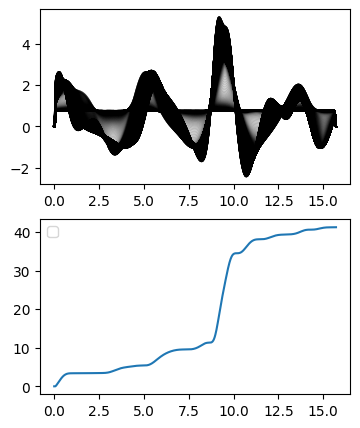

In [53]:
# NBVAL_IGNORE_OUTPUT
# the DensityMatrixODEPropagator is not sufficiently exact to guarantee that
# you won't get slightly different results in the optimization when
# running this on different systems
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options,
    tlist,
    iter_stop=20000,
    propagator=krotov.propagators.DensityMatrixODEPropagator(
        atol=1e-10, rtol=1e-8
    ),
    chi_constructor=chis_qubit,
    info_hook=krotov.info_hooks.chain(
        krotov.info_hooks.print_debug_information, print_qubit_error
    ),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('5e-3', name='J_T'),
        krotov.convergence.check_monotonic_error,
     ),
      store_all_pulses=True,
)

plot_iterations(opt_result)


In [54]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('Time')
    ax.set_ylabel('Pulse Amplitude')
    plt.show(fig)

In [55]:
def non_optimized(F,omega,tlist):
    non_opt=np.zeros(len(tlist))
    for i in range(0,len(tlist)):
        non_opt[i]=F*2*np.cos(omega*tlist[i])
    return non_opt

In [56]:
def purity_charger(state,tlist):
    purity=np.zeros(len(tlist))
    for i in range(0,len(tlist)):
        purity[i]=np.real(((state[i].ptrace(0))*(state[i].ptrace(0))).tr())
    return purity

In [57]:
def purity_battery(state,tlist):
    purity=np.zeros(len(tlist))
    for i in range(0,len(tlist)):
        purity[i]=np.real(((state[i].ptrace([1,2,3,4]))*(state[i].ptrace([1,2,3,4])))).tr()
    return purity

Text(0, 0.5, '$\\epsilon(t)$')

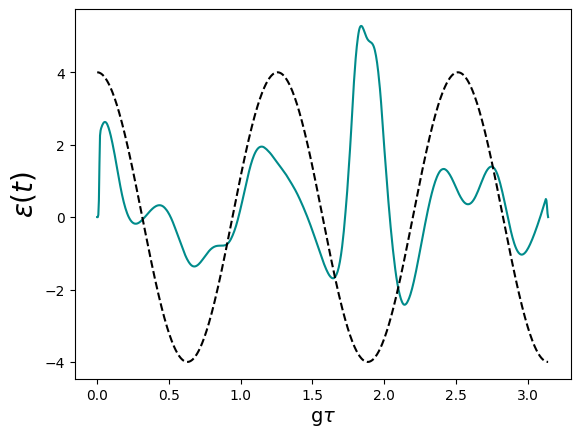

In [58]:
plt.plot(g*tlist,opt_result.optimized_controls[0],color='darkcyan')
plt.plot(g*tlist,non_optimized(2,1,tlist),color='black', linestyle='dashed')
plt.xlabel(r'g$\tau$',fontsize=14)
plt.ylabel(r'$\epsilon(t)$',fontsize=20)

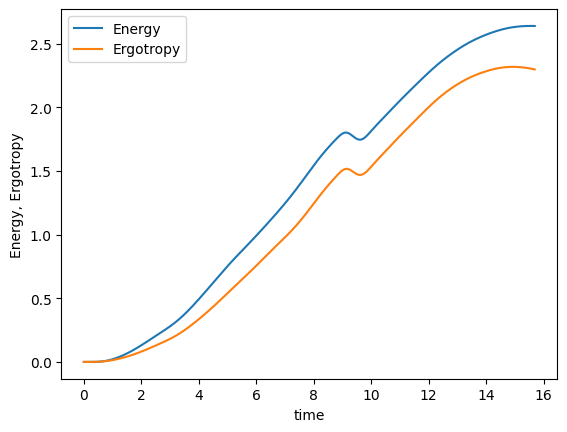

NameError: name 'Energy4' is not defined

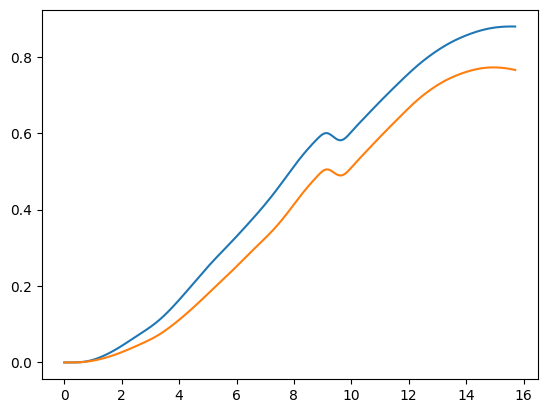

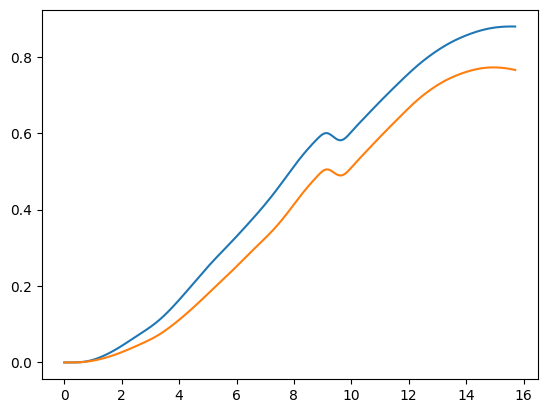

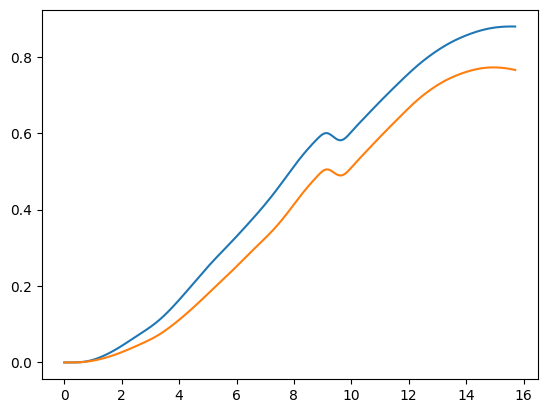

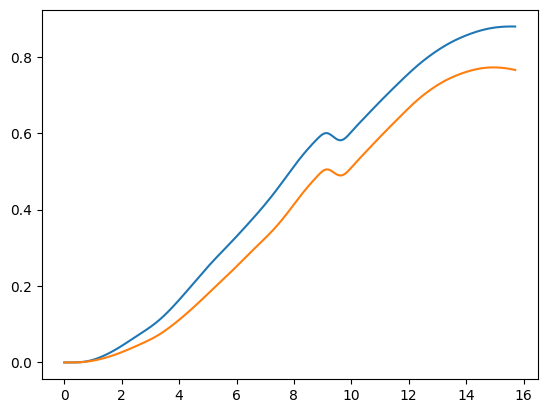

<Figure size 640x480 with 0 Axes>

In [59]:
from numpy import linalg as npla

def eigenvalues(A):
    eigenValues, eigenVectors = npla.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues)

optimized_dynamics = opt_result.optimized_objectives[0].mesolve(
      tlist, e_ops=[]
  )
Ergotropy=np.zeros(nt)
Energy=np.zeros(nt)
Ergotropy1=np.zeros(nt)
Energy1=np.zeros(nt)
Ergotropy2=np.zeros(nt)
Energy2=np.zeros(nt)
Ergotropy3=np.zeros(nt)
Energy3=np.zeros(nt)
time=np.zeros(nt)
puritycharger=np.zeros(nt)
puritybattery=np.zeros(nt)
population0=np.zeros(nt)
population1=np.zeros(nt)
population2=np.zeros(nt)
population3=np.zeros(nt)

for i in range(0,nt):
  FinalStateCharger= np.trace(np.array(optimized_dynamics.states[i]).reshape(2,8,2,8), axis1=1, axis2=3)
  #puritycharger[i]=np.real(np.trace(np.dot(FinalStateCharger,FinalStateCharger)))
  FinalStateB = np.trace(np.array(optimized_dynamics.states[i]).reshape(2,2,2,2,2,2,2,2), axis1=0, axis2=4)
  #population0[i]=FinalStateB[0,0]
  #population1[i]=FinalStateB[1,1]+FinalStateB[2,2]+FinalStateB[4,4]+FinalStateB[8,8]
  #population2[i]=FinalStateB[3,3]+FinalStateB[5,5]+FinalStateB[6,6]+FinalStateB[9,9]+FinalStateB[10,10]+FinalStateB[12,12]
  #population3[i]=FinalStateB[7,7]+FinalStateB[11,11]+FinalStateB[13,13]+FinalStateB[14,14]
  #population4[i]=FinalStateB[15,15]
  #puritybattery[i]=np.trace(np.dot(FinalStateB,FinalStateB))
  FinalStateCell1=np.trace(np.array(FinalStateB).reshape(2,4,2,4), axis1=1, axis2=3)
  PreFinalStateCell2=np.trace(np.array(FinalStateB).reshape(2,2,2,2,2,2), axis1=2, axis2=5)
  FinalStateCell2=np.trace(np.array(PreFinalStateCell2).reshape(2,2,2,2), axis1=0, axis2=2)
  PreFinalStateCell3=np.trace(np.array(FinalStateB).reshape(2,2,2,2,2,2), axis1=0, axis2=3)
  FinalStateCell3=np.trace(np.array(PreFinalStateCell2).reshape(2,2,2,2), axis1=1, axis2=3)
  Rho_fCell1=eigenvalues(FinalStateCell1)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell1)[0]*np.array([[0, 0], [0, 1]])
  Rho_fCell2=eigenvalues(FinalStateCell2)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell2)[0]*np.array([[0, 0], [0, 1]])
  Rho_fCell3=eigenvalues(FinalStateCell3)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell3)[0]*np.array([[0, 0], [0, 1]])
  Energy[i]=np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell3)))+np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell1)))+np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell2)))
  Ergotropy[i]=-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell3-FinalStateCell3))))-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell1-FinalStateCell1))))-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell2-FinalStateCell2))))
  time[i]=(T/nt)*i
  Energy1[i]=np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell1)))
  Ergotropy1[i]=-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell1-FinalStateCell1))))
  Energy2[i]=np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell2)))
  Ergotropy2[i]=-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell2-FinalStateCell2))))
  Energy3[i]=np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell3)))
  Ergotropy3[i]=-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell3-FinalStateCell3))))




plt.plot(time,Energy,label='Energy')
plt.plot(time,Ergotropy,label='Ergotropy')
plt.xlabel("time")
plt.ylabel("Energy, Ergotropy")
plt.legend()  
plt.show()


plt.figure()
plt.plot(tlist,Energy1)
plt.plot(tlist,Ergotropy1)


plt.figure()
plt.plot(tlist,Energy1)
plt.plot(tlist,Ergotropy1)


plt.figure()
plt.plot(tlist,Energy2)
plt.plot(tlist,Ergotropy2)


plt.figure()
plt.plot(tlist,Energy3)
plt.plot(tlist,Ergotropy3)

plt.figure()
plt.plot(tlist,Energy4)
plt.plot(tlist,Ergotropy4)

plt.figure()
plt.plot(tlist,puritycharger)


plt.figure()
plt.plot(tlist,puritybattery)


plt.figure()
plt.plot(tlist,population0,label='0')
plt.plot(tlist,population1,label='1')
plt.plot(tlist,population2,label='2')
plt.plot(tlist,population3,label='3')
plt.plot(tlist,population4,label='4')
plt.legend()

plt.show()

In [ ]:
#T=14.355726189827232#np.pi/g
EField=np.transpose(np.array(opt_result.optimized_controls))
EEnergy=np.zeros(len(tlist))
EEnergy[0]=(np.square(EField[0]))*(T/nt)
a=0
for i in range (1,nt):
    a+=np.square(EField[i-1])
    EEnergy[i]=(np.square(EField[i])+a)*(T/nt)

print(EEnergy[nt-1]*(0.75)**2)
a=opt_result.states[0].ptrace([1,2,3])
print(a[7,7])
a

In [ ]:
Power=np.zeros(nt)
dt=tlist[1]-tlist[0]
for j in range(0,nt):
  for i in range(0,j+1):
    Power[j]+=1/T*dt*Energy[i]

plt.plot(tlist,Power)
print(Power[nt-1])

In [26]:
def HA_coeff(t, args):
      return  np.exp(-(t*1j*omega))

def HB_coeff(t, args):
      return  np.exp((t*1j*omega))


def hamiltonian(omega, g,F):
    """Liouvillian for the coupled system of qubit and TLS"""
    sminus=qt.Qobj(np.array([[0,1],[0,0]]))
    splus=qt.Qobj(np.array([[0,0],[1,0]]))
    H0_q = omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2))
    # drive qubit Hamiltonian
    H1_A = F*splus
    H1_B = F*sminus

    # drift TLS Hamiltonian
    H0_T = qutip.tensor(omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)),qutip.qeye(2),qutip.qeye(2))\
                        +qutip.tensor(qutip.qeye(2), omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)),qutip.qeye(2))\
                        +qutip.tensor(qutip.qeye(2), qutip.qeye(2),omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)))

    # Lift Hamiltonians to joint system operators
    H0 = qutip.tensor(H0_q, qutip.qeye(2),qutip.qeye(2),qutip.qeye(2)) + qutip.tensor(qutip.qeye(2), H0_T)
    H1A = qutip.tensor(H1_A, qutip.qeye(2),qutip.qeye(2),qutip.qeye(2))
    H1B = qutip.tensor(H1_B, qutip.qeye(2),qutip.qeye(2),qutip.qeye(2))
    # qubit-TLS interaction
    H_int =  g*(qutip.tensor(sminus,splus,qutip.qeye(2),qutip.qeye(2))\
                +qutip.tensor(splus,sminus,qutip.qeye(2),qutip.qeye(2))\
                +qutip.tensor(sminus,qutip.qeye(2),splus,qutip.qeye(2))\
                +qutip.tensor(splus,qutip.qeye(2),sminus,qutip.qeye(2))\
                +qutip.tensor(sminus,qutip.qeye(2),qutip.qeye(2),splus)\
                +qutip.tensor(splus,qutip.qeye(2),qutip.qeye(2),sminus))\
    # convert Hamiltonians to QuTiP objects
    H0 = qutip.Qobj(H0 + H_int)
    H1A = qutip.Qobj(H1A)
    H1B = qutip.Qobj(H1B)
    return [H0,[H1A,HA_coeff],[H1B,HB_coeff]]

/tmp/ipykernel_553/3213597860.py:47: RuntimeWarning: invalid value encountered in double_scalars
  ratio[i]=ergotropy[i]/energy[i]
/tmp/ipykernel_553/3213597860.py:57: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(g*t,Ergotropy/Energy,color='darkcyan')


Text(0, 0.5, '$\\frac{\\mathcal{E}_{B}}{E_B}$')

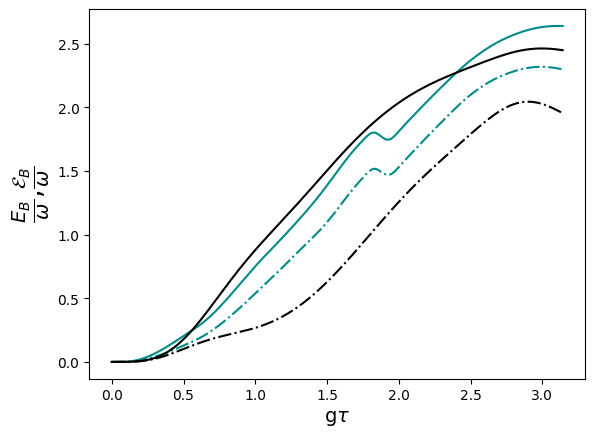

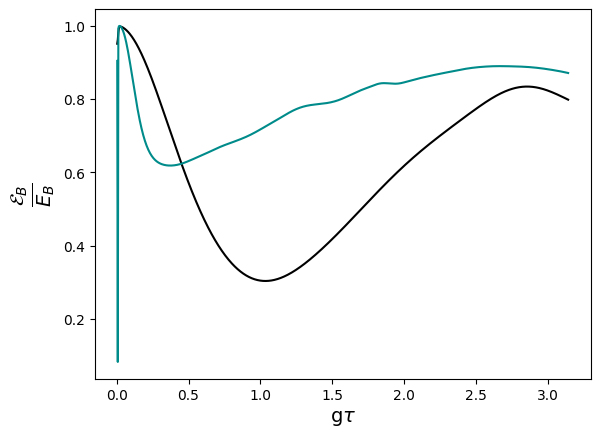

In [63]:
import qutip as qt
import numpy as np
from numpy import linalg as npla
sminus=qt.Qobj(np.array([[0,1],[0,0]]))
splus=qt.Qobj(np.array([[0,0],[1,0]]))
F=0.5
g=0.2
gamma=0.05

H=hamiltonian(omega,g,F)
psi0=qt.tensor(qt.basis(2,0),qt.basis(2,0),qt.basis(2,0),qt.basis(2,0))
T = np.pi/g # final time
nt = 800
t=np.linspace(0,T,nt)
N=0
H0 = qutip.tensor(omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)),qutip.qeye(2),qutip.qeye(2))\
                        +qutip.tensor(qutip.qeye(2), omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)),qutip.qeye(2))\
                        +qutip.tensor(qutip.qeye(2),qutip.qeye(2),omega*0.5*(-qutip.operators.sigmaz()+qutip.qeye(2)))

output = qt.mesolve(H, psi0, t, [qt.tensor(np.sqrt(gamma*(N+1))*sminus,qt.qeye(2),qt.qeye(2),qt.qeye(2)),qt.tensor(np.sqrt(gamma*N)*splus,qt.qeye(2),qt.qeye(2),qt.qeye(2))], [])
energy=np.zeros(len(t))
ergotropy=np.zeros(len(t))
ratio=np.zeros(len(t))
for i in range (0,len(t)):
  rho_A=output.states[i].ptrace([1,2,3])
  FinalStateCell1=np.array(rho_A.ptrace(0))
  FinalStateCell2=np.array(rho_A.ptrace(1))
  

  FinalStateCell3=np.array(rho_A.ptrace(2))
  #FinalStateCell4=np.array(rho_A.ptrace(3))
  Rho_fCell1=eigenvalues(FinalStateCell1)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell1)[0]*np.array([[0, 0], [0, 1]])
  Rho_fCell2=eigenvalues(FinalStateCell2)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell2)[0]*np.array([[0, 0], [0, 1]])
  Rho_fCell3=eigenvalues(FinalStateCell3)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell3)[0]*np.array([[0, 0], [0, 1]])
  #Rho_fCell4=eigenvalues(FinalStateCell4)[1]*np.array([[1, 0], [0, 0]])+eigenvalues(FinalStateCell4)[0]*np.array([[0, 0], [0, 1]])
  #energy[i]=np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell4)))+np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell3)))+np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell1)))+np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),FinalStateCell2)))
  ergotropy[i]=-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell3-FinalStateCell3))))-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell1-FinalStateCell1))))-np.real(np.matrix.trace(omega*np.dot(np.array([[0, 0], [0, 1]]),(Rho_fCell2-FinalStateCell2))))
  energy[i]=np.real((rho_A*H0).tr())

  #rho_f=qt.Qobj(eigenvalues(rho_A)[1]*qt.basis(2,0)*qt.basis(2,0).dag()+eigenvalues(rho_A)[0]*qt.basis(2,1)*qt.basis(2,1).dag())
  #r=np.sqrt(((rho_A*qt.sigmax()).tr())**2+((rho_A*qt.sigmay()).tr())**2+((rho_A*qt.sigmaz()).tr())**2)
  #sminusexp=(rho_A*sminus).tr()
  #splusexp=(rho_A*splus).tr()
  #zexp=(rho_A*qt.sigmaz()).tr()
  #energy[i]=np.real((rho_A*H0).tr())
  #ergotropy[i]=np.real(((rho_A-rho_f)*H0).tr())
  ratio[i]=ergotropy[i]/energy[i]
plt.plot(g*tlist,np.real(Energy),color='darkcyan')
plt.plot(g*tlist,np.real(Ergotropy),ls='dashdot',color='darkcyan')
plt.plot(g*t,np.real(energy),color='black')
plt.plot(g*t,np.real(ergotropy),ls='dashdot',color='black')
plt.xlabel(r'g$\tau$',fontsize=14)
plt.ylabel(r'$\frac{E_{B}}{\omega}$,$\frac{\mathcal{E}_{B}}{\omega}$',fontsize=20)
plt.savefig("4_qubit_cell.png")
plt.figure()
plt.plot(g*t,ratio,color='black')
plt.plot(g*t,Ergotropy/Energy,color='darkcyan')
plt.xlabel(r'g$\tau$',fontsize=14)
plt.ylabel(r'$\frac{\mathcal{E}_{B}}{E_B}$',fontsize=20)


In [28]:
### np.real(Ergotropy)[-1]/ergotropy[-1]

In [64]:
np.argmax(np.real(ergotropy))

738

In [66]:
t[738]

14.50873202972007

In [70]:
Ergotropy[-1]

2.2968130043773014

In [71]:
ergotropy[-1]

1.9533013500170164

In [69]:
import pruebas
pruebas.field_energy(opt_result,tlist,T,nt)/2

20.64074403670562

In [33]:
(( 29 / 25.03)-1)*100

15.860966839792233

In [72]:
np.pi/g

15.707963267948966

## Simulate the dynamics of the optimized field

The plot of the optimized field shows that the optimization slightly shifts
the field such that qubit and TLS are no longer perfectly in resonance.

This slight shift of qubit and TLS out of resonance delays the population
oscillations between qubit and TLS ground state such that the qubit ground
state is maximally populated at final time $T$.

In [ ]:
print(Ergotropy[nt-1]/Energy[nt-1])
print(Ergotropy[nt-1])